## Necessary Imports

In [1]:
import math
import os
import json

import tensorflow as tf
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

2022-04-20 21:42:00.869584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Helper Function Definitions

In [2]:
def print_report(y_test, y_pred):
  print("Accuracy Score is:\t {0:.3f}".format(accuracy_score(y_test, y_pred)))
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

In [3]:
def load_data(data_path):
    
    with open(data_path,"r") as fp:
        data = json.load(fp)
    
    genres = data['mapping']
    x = np.array(data['mfcc'])
    y = np.array(data["labels"])
    
    return genres, x, y

In [4]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [5]:
def prepare_datasets(X_train, y_train, validation_size):
    ##### CNN Specific Dataloader #####
    
    # create train, validation and test split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    return X_train, X_val, y_train, y_val

In [6]:
def replace_intermediate_layer_in_keras(model, layer_id, new_layer):
    
    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        else:
            x = layers[i](x)

    new_model = keras.models.Model(layers[0].input, x)
    return new_model

In [7]:
def predict_genre(model, song_mfcc, y_true):
    """
    Given a song, predict it's label (using a keras model)
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    song_mfcc = song_mfcc[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(song_mfcc)

    # get index with max value
    y_pred = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y_true, y_pred))

## Load Data & Develop Test/Train Splits

In [8]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_metadata.json"
GTZAN_JSON_PATH = "/storage/graham/music/gtzan.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [9]:
%%time
genres, X, y = load_data(FMA_JSON_PATH)

CPU times: user 2min 29s, sys: 11.9 s, total: 2min 41s
Wall time: 2min 41s


In [10]:
SPLIT = 0.3

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT)

# reshape MFCC to be a vector
X_train_vec = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_vec = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

X_vec = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

## Data Visualization with t-SNE

In [11]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X_vec)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:94: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:110: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 75192 samples in 0.768s...
[t-SNE] Computed neighbors for 75192 samples in 25.666s...
[t-SNE] Computed conditional probabilities for sample 1000 / 75192
[t-SNE] Computed conditional probabilities for sample 2000 / 75192
[t-SNE] Computed conditional probabilities for sample 3000 / 75192
[t-SNE] Computed conditional probabilities for sample 4000 / 75192
[t-SNE] Computed conditional probabilities for sample 5000 / 75192
[t-SNE] Computed conditional probabilities for sample 6000 / 75192
[t-SNE] Computed conditional probabilities for sample 7000 / 75192
[t-SNE] Computed conditional probabilities for sample 8000 / 75192
[t-SNE] Computed conditional probabilities for sample 9000 / 75192
[t-SNE] Computed conditional probabilities for sample 10000 / 75192
[t-SNE] Computed conditional probabilities for sample 11000 / 75192
[t-SNE] Computed conditional probabilities for sample 12000 / 75192
[t-SNE] Computed conditional probabilities for s

<Figure size 1728x1296 with 0 Axes>

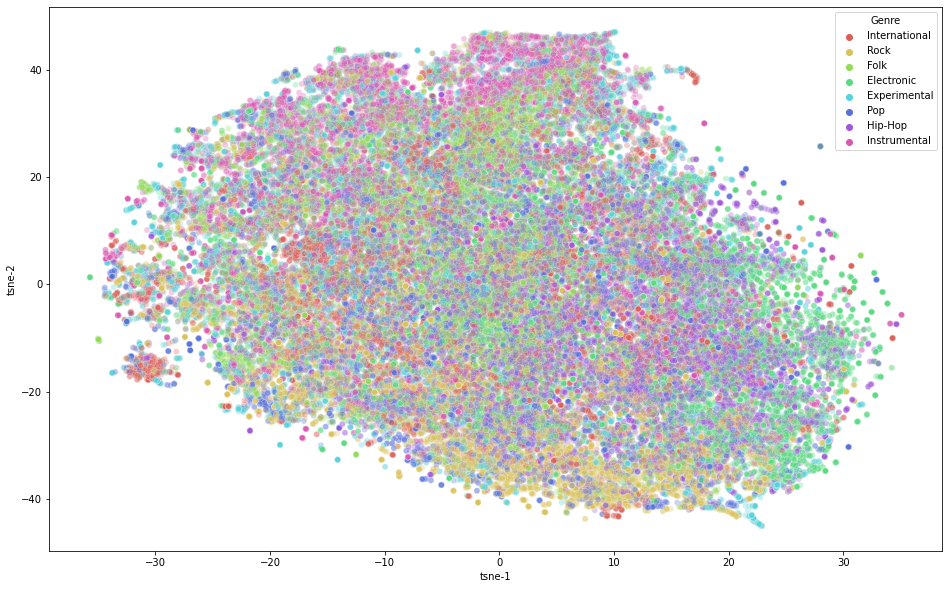

In [12]:
df_subset=pd.DataFrame()
df_subset['tsne-1'] = tsne_results[:,0]
df_subset['tsne-2'] = tsne_results[:,1]

# apply labels
labs = [genres[x] for x in y]
df_subset['Genre'] = labs

plt.figure(figsize=(24,18))
plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne-1', 
                y='tsne-2',
                hue='Genre',
                palette=sns.color_palette('hls', 8), 
                data=df_subset, 
                legend='full', 
                alpha=0.3
)
plt.show()

## Train Classical Models

### K-Nearest Neighbors Classifier

In [13]:
%%time
KNNmodel = KNeighborsClassifier(n_neighbors=10)
KNNmodel.fit(X_train_vec,y_train)
y_pred_knn = KNNmodel.predict(X_test_vec)

print_report(y_test, y_pred_knn)

Accuracy Score is:	 0.367
              precision    recall  f1-score   support

           0       0.40      0.47      0.43      2745
           1       0.24      0.58      0.34      2809
           2       0.43      0.33      0.37      2818
           3       0.81      0.09      0.16      2864
           4       0.34      0.60      0.43      2837
           5       0.65      0.18      0.28      2780
           6       0.51      0.15      0.23      2912
           7       0.43      0.56      0.49      2793

    accuracy                           0.37     22558
   macro avg       0.48      0.37      0.34     22558
weighted avg       0.48      0.37      0.34     22558

[[1278  669  117   24  320   38   63  236]
 [ 150 1623  175    3  516   55   51  236]
 [ 174  748  928    3  729   28   53  155]
 [ 627  874  134  257  307   53   70  542]
 [ 141  605  235    3 1700   19   31  103]
 [ 311  771  235   11  568  506   59  319]
 [ 353  856  212   15  542   65  432  437]
 [ 201  490  107    3 

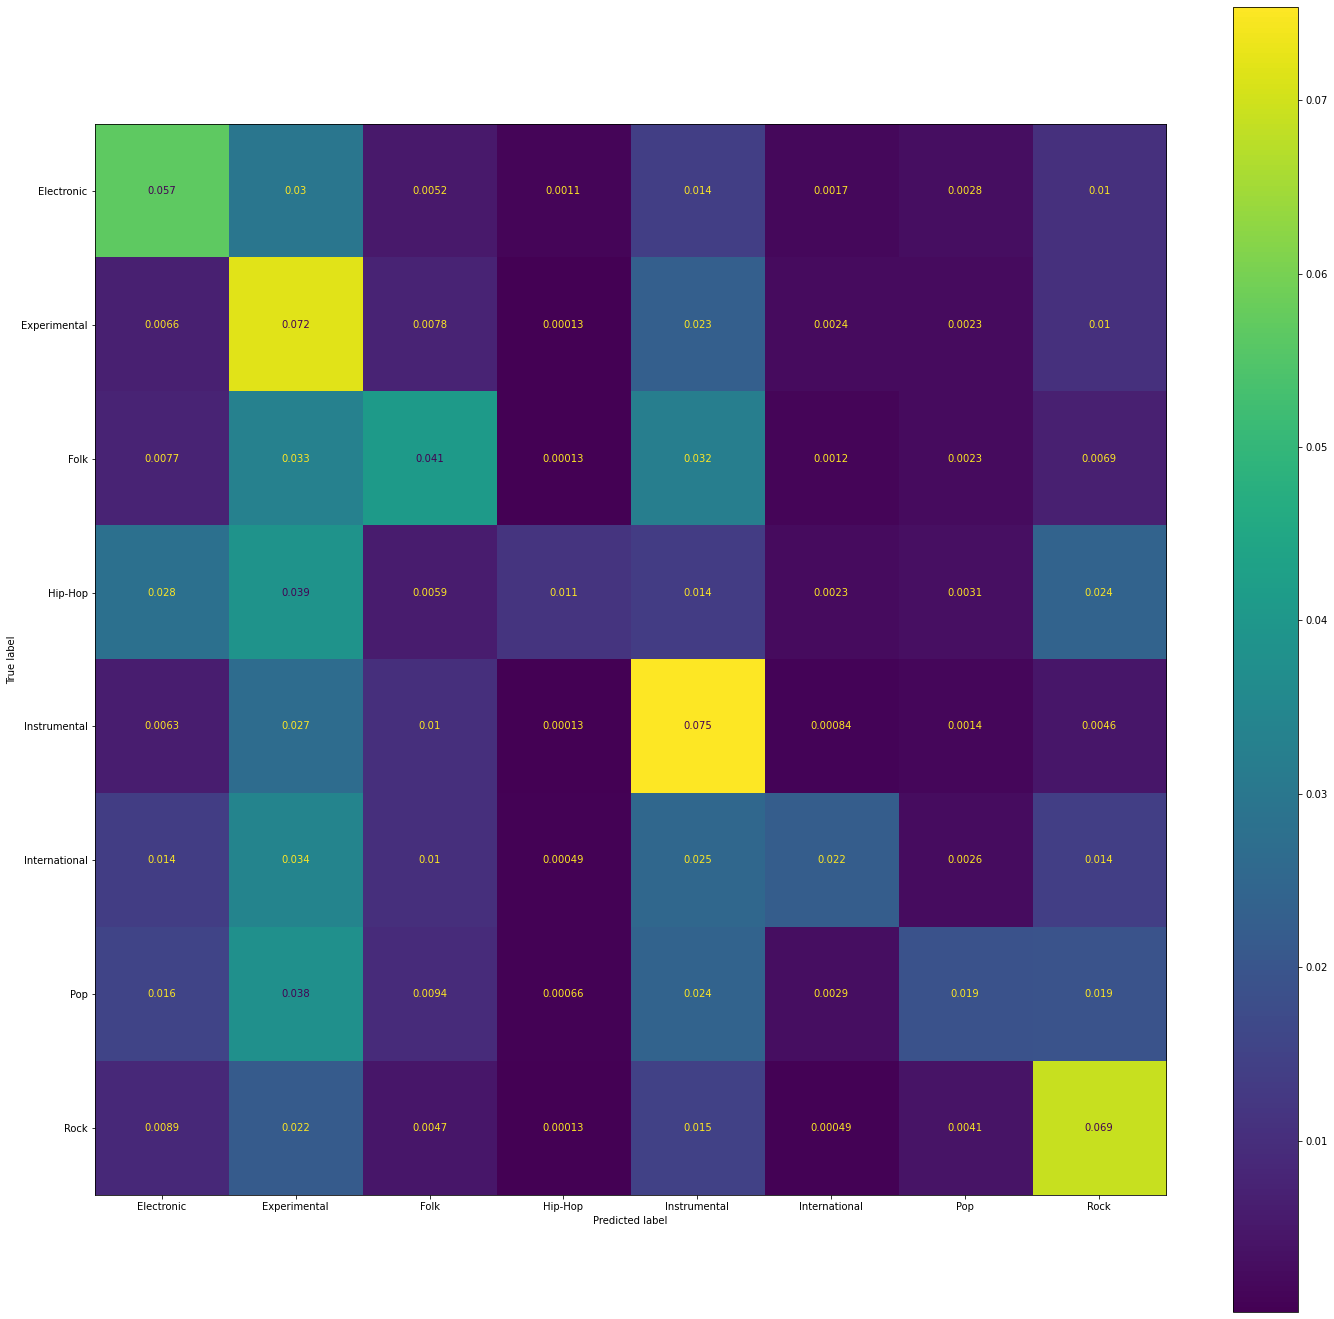

In [14]:
cm = confusion_matrix(y_test, y_pred_knn, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Support Vector Machine Classifier

In [15]:
%%time
SVMmodel = SVC()
SVMmodel.fit(X_train_vec,y_train)
y_pred_svm =  SVMmodel.predict(X_test_vec)

print_report(y_test, y_pred_svm)

Accuracy Score is:	 0.418
              precision    recall  f1-score   support

           0       0.44      0.44      0.44      2745
           1       0.41      0.20      0.27      2809
           2       0.40      0.54      0.46      2818
           3       0.44      0.54      0.49      2864
           4       0.45      0.52      0.48      2837
           5       0.36      0.42      0.39      2780
           6       0.28      0.12      0.17      2912
           7       0.48      0.56      0.52      2793

    accuracy                           0.42     22558
   macro avg       0.41      0.42      0.40     22558
weighted avg       0.41      0.42      0.40     22558

[[1197   96  173  560  259  214  102  144]
 [ 214  557  420  155  596  435  124  308]
 [  61   95 1535  131  377  281  175  163]
 [ 502   56  110 1554   70  271  115  186]
 [ 109  164  533   93 1479  192  116  151]
 [ 219  135  425  403  124 1171  135  168]
 [ 275  158  406  394  244  509  355  571]
 [ 169   94  265  206 

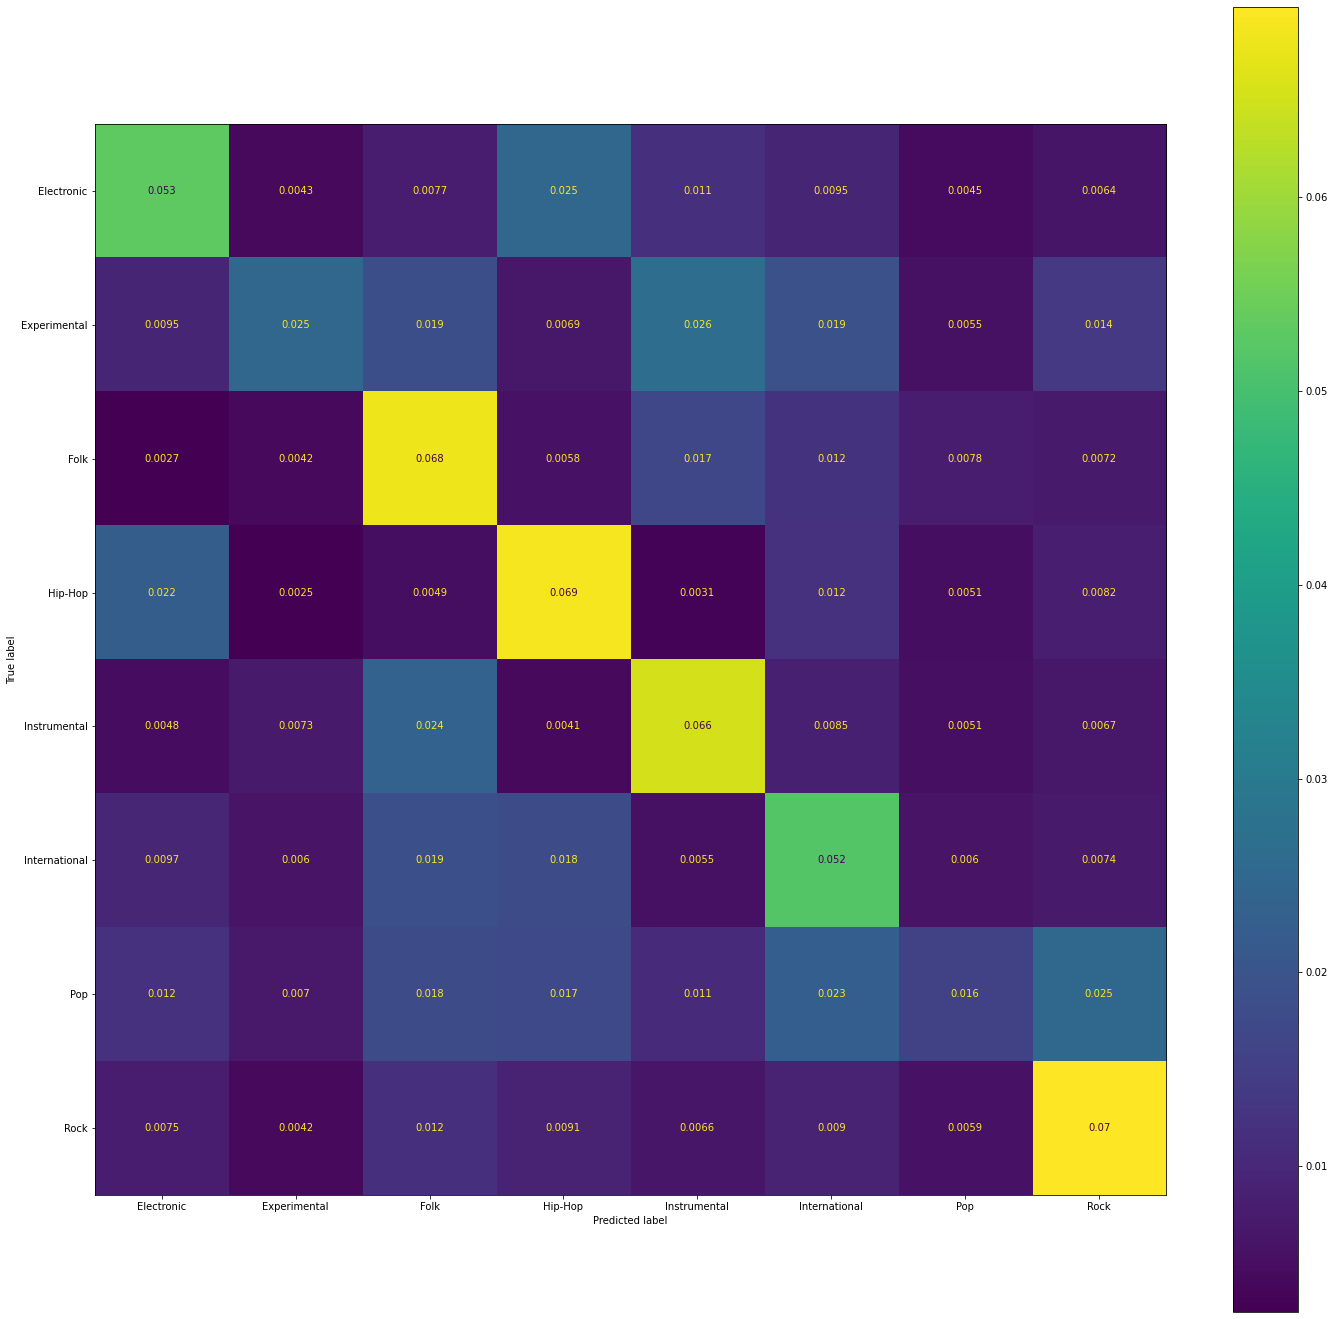

In [16]:
cm = confusion_matrix(y_test, y_pred_svm, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Decision Tree Classifier

In [17]:
%%time
DTmodel = DecisionTreeClassifier()
DTmodel.fit(X_train_vec, y_train)
y_pred_dt =  DTmodel.predict(X_test_vec)

print_report(y_test, y_pred_dt)

Accuracy Score is:	 0.279
              precision    recall  f1-score   support

           0       0.29      0.29      0.29      2745
           1       0.26      0.26      0.26      2809
           2       0.30      0.29      0.29      2818
           3       0.29      0.27      0.28      2864
           4       0.33      0.33      0.33      2837
           5       0.25      0.25      0.25      2780
           6       0.19      0.19      0.19      2912
           7       0.34      0.35      0.34      2793

    accuracy                           0.28     22558
   macro avg       0.28      0.28      0.28     22558
weighted avg       0.28      0.28      0.28     22558

[[804 281 192 436 227 268 303 234]
 [274 735 344 190 397 304 298 267]
 [207 310 827 163 441 332 333 205]
 [444 241 190 763 164 373 387 302]
 [207 400 419 136 946 206 289 234]
 [240 313 336 332 220 708 361 270]
 [335 326 289 348 301 361 545 407]
 [234 255 202 274 195 256 407 970]]
CPU times: user 5min 14s, sys: 65.1 ms, to

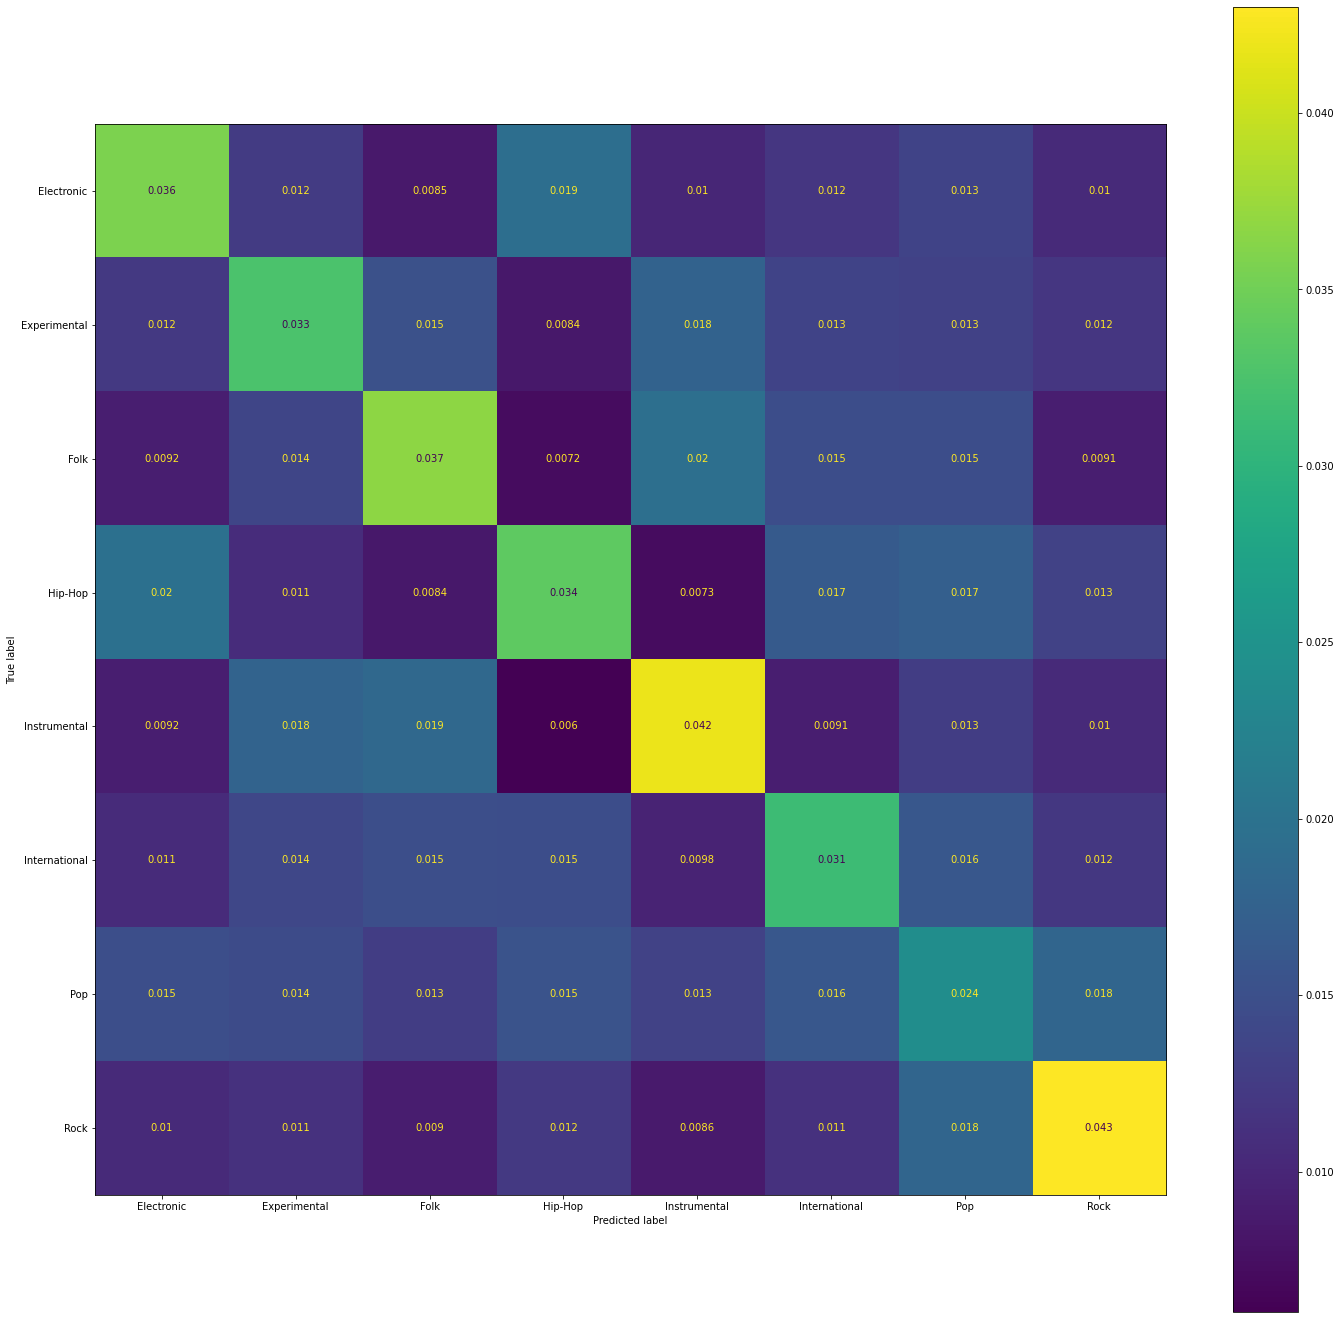

In [18]:
cm = confusion_matrix(y_test, y_pred_dt, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Gradient Boosted Classifier

In [19]:
%%time
XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_vec, y_train)
y_pred_xgb =  XGBmodel.predict(X_test_vec)

print_report(y_test, y_pred_xgb)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score is:	 0.464
              precision    recall  f1-score   support

           0       0.48      0.48      0.48      2745
           1       0.45      0.34      0.38      2809
           2       0.45      0.56      0.49      2818
           3       0.53      0.57      0.55      2864
           4       0.50      0.54      0.52      2837
           5       0.43      0.44      0.43      2780
           6       0.32      0.23      0.27      2912
           7       0.52      0.57      0.54      2793

    accuracy                           0.46     22558
   macro avg       0.46      0.46      0.46     22558
weighted avg       0.46      0.46      0.46     22558

[[1307  166  156  418  213  176  173  136]
 [ 185  945  343  124  468 

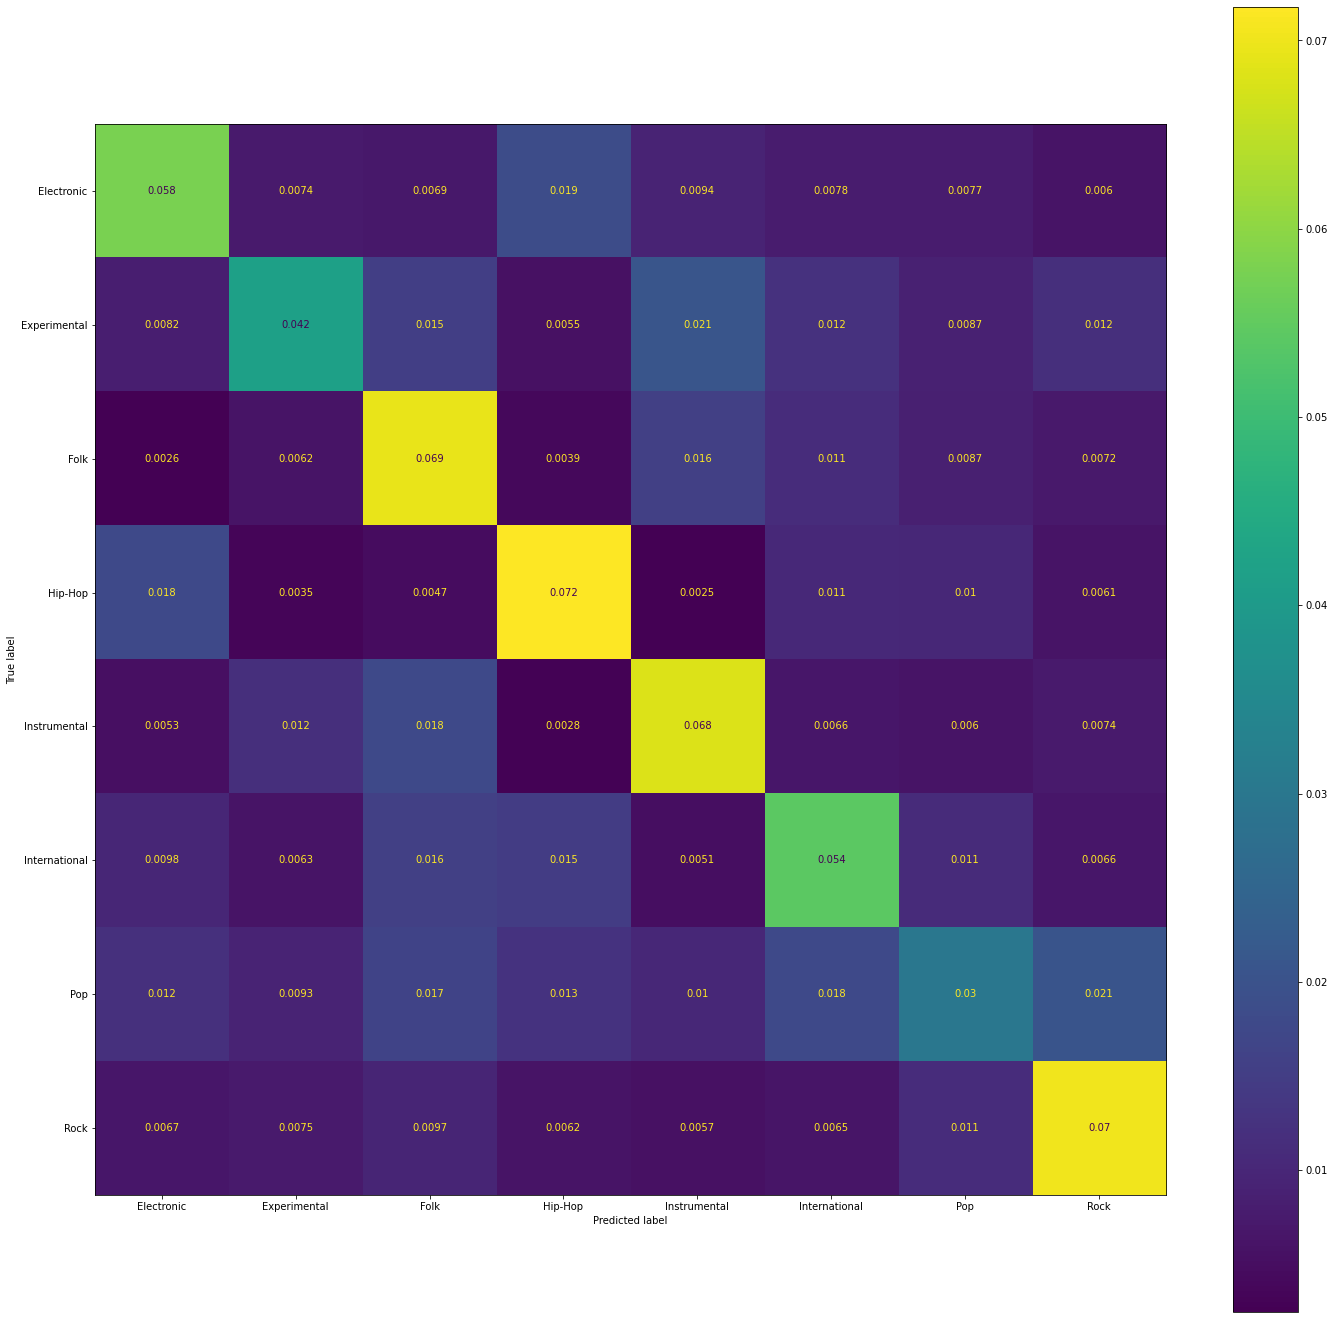

In [20]:
cm = confusion_matrix(y_test, y_pred_xgb, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

## Deep Learning Methods

### Fully Connected Neural Network (Multi-Layer Perceptron)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3367)              0         
                                                                 
 dense (Dense)               (None, 512)               1724416   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

Epoch 47/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6957 - accuracy: 0.3959 - val_loss: 1.7087 - val_accuracy: 0.3979
Epoch 48/100
1645/1645 [==============================] - 11s 6ms/step - loss: 1.6916 - accuracy: 0.3976 - val_loss: 1.6827 - val_accuracy: 0.4023
Epoch 49/100
1645/1645 [==============================] - 11s 6ms/step - loss: 1.6902 - accuracy: 0.3978 - val_loss: 1.7065 - val_accuracy: 0.3948
Epoch 50/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6901 - accuracy: 0.4005 - val_loss: 1.6905 - val_accuracy: 0.4098
Epoch 51/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6842 - accuracy: 0.4011 - val_loss: 1.6939 - val_accuracy: 0.4026
Epoch 52/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6891 - accuracy: 0.3995 - val_loss: 1.6816 - val_accuracy: 0.4015
Epoch 53/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6831 - accuracy: 0.4034 - val_loss: 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1645/1645 [==============================] - 11s 7ms/step - loss: 1.6431 - accuracy: 0.4203 - val_loss: 1.6792 - val_accuracy: 0.4147
Epoch 87/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6396 - accuracy: 0.4230 - val_loss: 1.6837 - val_accuracy: 0.4088
Epoch 88/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6371 - accuracy: 0.4242 - val_loss: 1.6730 - val_accuracy: 0.4166
Epoch 89/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6377 - accuracy: 0.4240 - val_loss: 1.6596 - val_accuracy: 0.4206
Epoch 90/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6382 - accuracy: 0.4240 - val_loss: 1.6855 - val_accuracy: 0.4081
Epoch 91/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6314 - accuracy: 0.4263 - val_loss: 1.6799 - val_accuracy: 0.4073
Epoch 92/100
1645/1645 [==============================] - 11s 7ms/step - loss: 1.6341 - accuracy: 0.4277 - val_loss: 1.6671 - val_a

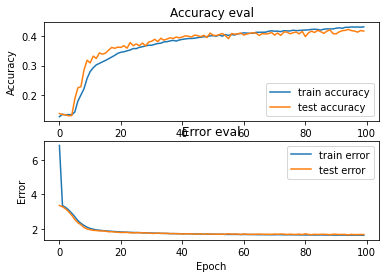

INFO:tensorflow:Assets written to: /storage/graham/music/models//mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//mlp/assets


CPU times: user 18h 52min 4s, sys: 2h 31min 42s, total: 21h 23min 47s
Wall time: 18min 11s


In [21]:
%%time
# build network topology
mlp = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(len(genres), activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
mlp.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

mlp.summary()

# train model
history = mlp.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

# plot accuracy and error as a function of the epochs
plot_history(history)

# save model
mlp.save(MODEL_PATH + "/mlp/")

## Convolutional Neural Network Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 129, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 2, 32)        0         
 2D)                                                             
                                                      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1645/1645 [==============================] - 31s 19ms/step - loss: 1.1711 - accuracy: 0.5804 - val_loss: 1.3275 - val_accuracy: 0.5383
Epoch 12/30
1645/1645 [==============================] - 32s 19ms/step - loss: 1.1516 - accuracy: 0.5861 - val_loss: 1.3129 - val_accuracy: 0.5449
Epoch 13/30
1645/1645 [==============================] - 32s 20ms/step - loss: 1.1364 - accuracy: 0.5923 - val_loss: 1.3240 - val_accuracy: 0.5421
Epoch 14/30
1645/1645 [==============================] - 32s 20ms/step - loss: 1.1227 - accuracy: 0.5971 - val_loss: 1.3371 - val_accuracy: 0.5384
Epoch 15/30
1645/1645 [==============================] - 32s 20ms/step - loss: 1.1048 - accuracy: 0.6049 - val_loss: 1.2770 - val_accuracy: 0.5576
Epoch 16/30
1645/1645 [==============================] - 32s 20ms/step - loss: 1.0895 - accuracy: 0.6076 - val_loss: 1.3242 - val_accuracy: 0.5440
Epoch 17/30
1645/1645 [==============================] - 31s 19ms/step - loss: 1.0794 - accuracy: 0.6109 - val_loss: 1.3226 - val_

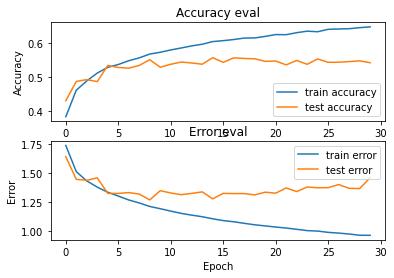

705/705 - 3s - loss: 0.9823 - accuracy: 0.6618 - 3s/epoch - 4ms/step

Test accuracy: 0.6618494391441345
INFO:tensorflow:Assets written to: /storage/graham/music/models//cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//cnn/assets


In [22]:
# get train, validation, test splits
X_train, X_val, y_train, y_val = prepare_datasets(X, y, 0.3)

### Build CNN Model ###
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# build network topology
cnn = keras.Sequential()

# 1st conv layer
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(64, activation='relu'))
cnn.add(keras.layers.Dropout(0.3))

# output layer
cnn.add(keras.layers.Dense(len(genres), activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.summary()

# train model
history = cnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# save model
cnn.save(MODEL_PATH + "/cnn/")

## Transfer Learning to GTZAN

### Load in GTZAN Dataset

In [23]:
%%time
genres_gtzan, X_gtzan, y_gtzan = load_data(GTZAN_JSON_PATH)

CPU times: user 3.13 s, sys: 300 ms, total: 3.43 s
Wall time: 3.43 s


In [24]:
SPLIT = 0.3

# create train/test split
X_gtzan_train, X_gtzan_test, y_gtzan_train, y_gtzan_test = train_test_split(X_gtzan, y_gtzan, test_size=SPLIT)

# reshape MFCC to be a vector
X_gtzan_train_vec = X_gtzan_train.reshape(X_gtzan_train.shape[0],X_gtzan_train.shape[1]*X_gtzan_train.shape[2])
X_gtzan_test_vec = X_gtzan_test.reshape(X_gtzan_test.shape[0],X_gtzan_test.shape[1]*X_gtzan_test.shape[2])

X_gtzan_vec = X_gtzan.reshape(X_gtzan.shape[0], X_gtzan.shape[1]*X_gtzan.shape[2])

In [25]:
%%time
gtzan_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
gtzan_tsne_results = tsne.fit_transform(X_gtzan_vec)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1870 samples in 0.020s...
[t-SNE] Computed neighbors for 1870 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1870


/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:94: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:110: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


[t-SNE] Computed conditional probabilities for sample 1870 / 1870
[t-SNE] Mean sigma: 395.346306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.328346
[t-SNE] KL divergence after 1000 iterations: 1.249881
CPU times: user 15min 8s, sys: 31.4 s, total: 15min 40s
Wall time: 5.42 s


<Figure size 1728x1296 with 0 Axes>

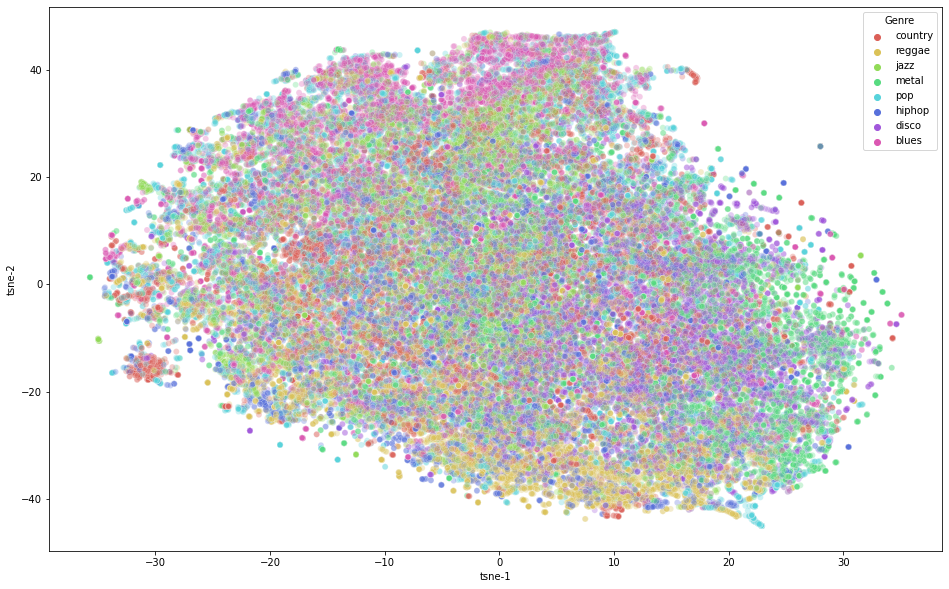

In [26]:
df_gtzan=pd.DataFrame()
df_gtzan['tsne-1'] = tsne_results[:,0]
df_gtzan['tsne-2'] = tsne_results[:,1]

# apply labels
labs = [genres_gtzan[x] for x in y]
df_gtzan['Genre'] = labs

plt.figure(figsize=(24,18))
plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne-1', 
                y='tsne-2',
                hue='Genre',
                palette=sns.color_palette('hls', 8), 
                data=df_gtzan, 
                legend='full', 
                alpha=0.3
)
plt.show()

### Load Previous CNN Model

In [27]:
base_model = keras.models.load_model(MODEL_PATH + "/cnn/")
for layer in base_model.layers:
    if layer.name == 'dense_4':
        break
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer conv2d frozen.
Layer max_pooling2d frozen.
Layer batch_normalization frozen.
Layer conv2d_1 frozen.
Layer max_pooling2d_1 frozen.
Layer batch_normalization_1 frozen.
Layer conv2d_2 frozen.
Layer max_pooling2d_2 frozen.
Layer batch_normalization_2 frozen.
Layer flatten_1 frozen.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 129, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (Non

### Replace Last Layer to Match GTZAN Dimensionality

In [28]:
gtzan_predict = keras.layers.Dense(len(genres_gtzan), activation='softmax', name='gtzan')
gtzan_transfer = replace_intermediate_layer_in_keras(base_model, 12, gtzan_predict)
gtzan_transfer._name = "FMA_Transfer_to_GTZAN"
gtzan_transfer.summary()

Model: "FMA_Transfer_to_GTZAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 259, 13, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 129, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 2, 3

### Fine Tune on GTZAN Data

Epoch 1/30
29/29 [==============================] - 1s 15ms/step - loss: 3.1122 - accuracy: 0.1812 - val_loss: 1.5888 - val_accuracy: 0.4046
Epoch 2/30
29/29 [==============================] - 0s 9ms/step - loss: 1.5816 - accuracy: 0.4531 - val_loss: 1.1418 - val_accuracy: 0.5700
Epoch 3/30
29/29 [==============================] - 0s 10ms/step - loss: 1.1679 - accuracy: 0.5622 - val_loss: 0.9580 - val_accuracy: 0.6438
Epoch 4/30
29/29 [==============================] - 0s 9ms/step - loss: 0.9653 - accuracy: 0.6365 - val_loss: 0.8624 - val_accuracy: 0.6667
Epoch 5/30
29/29 [==============================] - 0s 8ms/step - loss: 0.7949 - accuracy: 0.6998 - val_loss: 0.8042 - val_accuracy: 0.6768
Epoch 6/30
29/29 [==============================] - 0s 8ms/step - loss: 0.6903 - accuracy: 0.7424 - val_loss: 0.7676 - val_accuracy: 0.6896
Epoch 7/30
29/29 [==============================] - 0s 9ms/step - loss: 0.6251 - accuracy: 0.7718 - val_loss: 0.7377 - val_accuracy: 0.6947
Epoch 8/30
29/29 [

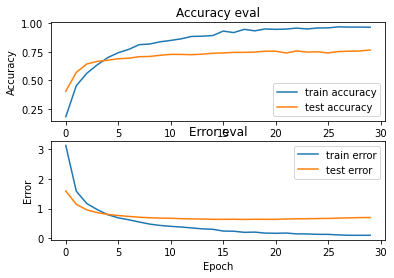

18/18 - 0s - loss: 0.6729 - accuracy: 0.7558 - 194ms/epoch - 11ms/step

Test accuracy: 0.7557932138442993
CPU times: user 4min 6s, sys: 42.5 s, total: 4min 49s
Wall time: 8.49 s


In [29]:
%%time
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
gtzan_transfer.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# prep data for CNN
X_gtzan_cnn_train, X_gtzan_val, y_gtzan_cnn_train, y_gtzan_val = prepare_datasets(X_gtzan_train, y_gtzan_train, 0.3)

# train model
history = gtzan_transfer.fit(X_gtzan_cnn_train, y_gtzan_cnn_train, validation_data=(X_gtzan_val, y_gtzan_val), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = gtzan_transfer.evaluate(X_gtzan_test, y_gtzan_test, verbose=2)
print('\nTest accuracy:', test_acc)